# generating influence diagrams; Switch / Light example


## using a system model described in literature

Sources:
- TNO report: Guided root analysis of machine failure
- article: Differential diagnosis with Active Testing


Definitions:
a system is an assembly of components + connections between components

how to define a component?
- define inputs and outputs
- define failure modes
- inputs and outputs are associated with modalities and a modality has properties
- relation between inputs and outputs for normal behavior and for every failure mode

how to define an assembly
- components that are part of the assembly
- how the components are connected


Additional definitions necessary for generating an influence diagram
how to define a replace decision?
- defined as part of component 
- connected to health and a utility

how to define observation tests?
- specify component under test
- model testdecision + utility

limitations/prerequisites for this implementation:
- every component has one health and one output variable. multiple inputs are possible
- type names for components / connections are unique
- variable names are unique and follow strict convention "PropertyModalityInputsName"

### steps to generate influence diagram from a system definition

implementation below uses following steps
- define system
  - define components (inputs/outputs, ...) as dict
  - define connections as dict
  - define system as dict
  
- create diagram based on system definition
  - generate nodes from dicts in system specification and add to influence diagram
  - generate arcs from dict and add to influence diagram
  
- determine probabilities based on specified normal behavior, normal behavior is specified at component/connector level
- TODO add failure modes

- add replacement decisions for every component, utility uses costs
- TODO add replacement decisions for connections

- TODO add tests to ID (only tests of health)

- TODO perform diagnosis scenario's
  - inference
  - decide best test

## System specification

### component specification

- a component has a unique name
- every component has one or more inputs, 
- every component has one output
- every component has one health
- every component has a type
- inputs/outputs/health have modalities which have properties which have values

probabilities
- Health nodes don't have parents, priors can be determined before hand and specified based on experience, data etc. A health node has a state for normal behavior and for every failure mode. The priors are part of the health node specification. 
- A table specifies "normal behavior" via relations between input and output states. Since relations in components are deterministic (par 5.2.3) 0 and 1 are used. Note is that the "ALWAYS" and "ELSE" keywords are not yet used in the table.

decisions
- according to Joep's thesis the replacement decision utility depends on:
  - Healthy + not replace     : 0
  - Healthy + replace         : replacement + incorrect replacement costs
  - not healthy + not replace : failure to repair
  - not healthy + replace     : replacement cost
- these costs are specified in the components



In [228]:
# component Switch > Python datastructure dictionary

switch = {
    "type":"Switch",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        },
        "2":
        {
            "modality":"State",
            "property":"Enabled",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.99,0.01]        }
    },
    "Outputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.99,0.01]
        }
    },
    "Decisions":{
        "1":{
            "name":"Replace",
            "values":["yes", "no"],
            "replacementcosts": 2,
            "incorrectreplacementcosts": 3,
            "failuretorepaircosts": 4
            }
    },
    # normal behavior definition, example: all inputs:"yes" + output: "yes" + health:"ok" is a normal state (specified in "columns" below)
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "yes","no" , "no"], 
            'EnabledStateInputs':  ["yes", "no" ,"yes", "no"],
            'PresentPowerOutputs': ["yes", "no" ,"no" , "no"],
            'health':              ["ok",  "ok" , "ok", "ok"]
        }
    }
}

In [229]:
# component Light > Python datastructure dictionary

light = {
    "type":"Light",
    "Inputs":{
        "1":{
            "modality":"Power",
            "property":"Present",
            "propertyvalues":["yes", "no"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Outputs":{
        "1":{
            "modality":"Light",
            "property":"Present",
            "propertyvalues":["yes", "no"]
        }
    },
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Decisions":{
        "1":{
            "name":"Replace",
            "values":["yes", "no"],
            "replacementcosts": 2,
            "incorrectreplacementcosts": 3,
            "failuretorepaircosts": 4
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs':  ["yes", "no"], 
            'PresentLightOutputs': ["yes", "no"],
            'health':              ["ok",  "ok"]
        }
    }

}

### connections connect components 
- connections have a name and type
- connections have two typed components and a direction (start -> end)
- connections have a health that is connected to the component that is addressed by the connection: end
- a table specifies the relation between start and end component states considered normal
- health node has states for OK and for failure states



In [230]:
wire = {
    "type":"Wire",
    "start":"PresentPowerOutputs",
    "typeStart":"Switch",
    "end":"PresentPowerInputs",
    "typeEnd":"Light",
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerInputs' :   ["yes"],
            'PresentPowerOutputs':   ["yes"],
            'health'             :   ["ok"]
        }
    }
}

wire2 = {
    "type":"Wire2",
    "start":"PresentLightOutputs",
    "typeStart":"Light",
    "end":"PresentPowerInputs",
    "typeEnd":"Switch",
    "Healths":{
        "1":{
            "modality":"Health",
            "property":"health",
            "propertyvalues":["ok","broken"],
            "priorprobability":[0.9,0.1]
        }
    },
    "Behavior":{
        "normal": {
            'PresentPowerOutputs':   ["yes"],
            'PresentPowerInputs' :   ["yes"],
            'health'             :   ["ok"]
        }
    }
}

### system defines assembly
system consists of components and connections between them defined via the "structures" below

In [231]:
# small structure
structure = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        }
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        }
    }
}

# more components and connections
structure3 = {
    "components": {
        "1":{
            "name":"Light",
            "type":"Light"
        },
        "2":{
            "name":"Switch",
            "type":"Switch"           
        },
        "3":{
            "name":"Light1",
            "type":"Light"
        },
        "4":{
            "name":"Switch1",
            "type":"Switch"           
        },
        "5":{
            "name":"Light2",
            "type":"Light"
        },
        "6":{
            "name":"Switch2",
            "type":"Switch"           
        },
    },
    "connections":{
        "1":{
            "name":"Wire",
            "type":"Wire",
            "startComponent":"Switch",
            "endComponent":"Light"
        },
        "2":{
            "name":"Wire2",
            "type":"Wire2",
            "startComponent":"Light",
            "endComponent":"Switch1"
        },
        "3":{
            "name":"Wire3",
            "type":"Wire",
            "startComponent":"Switch1",
            "endComponent":"Light1"
        },
        "4":{
            "name":"Wire4",
            "type":"Wire2",
            "startComponent":"Light1",
            "endComponent":"Switch2"
        },
        "5":{
            "name":"Wire5",
            "type":"Wire",
            "startComponent":"Switch2",
            "endComponent":"Light2"
        }

    }
}


## generate influence diagram structure

In [232]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML
import re

In [233]:
# purpose: add Components from system structure to diagram

# diag: pyagrum influence diagram
# comp: specification of 1 component as dict
# name: name to use for component in diagram

# result: nodes for 1 component added to diagram

# per modality a variable is generated and added to diagram
# arcs are created to connect inputs to output and health to output

def addComponentToDiagram(diag, comp, name):
    
    # specifcation contains three relevant sections
    componentCategories = ["Inputs","Outputs","Healths"]
    
    # get keys dict specifying component
    keys = comp.keys()

    # read inputs, outputs and health specs, add named variable to diagram 
    varLabels = []    
    for ckey in componentCategories:
        if ckey in keys:  
            for modality in comp[ckey].keys():                                             # get modalities
                modalitylabel = comp[ckey][modality]["modality"]                           # get modality label
                property = comp[ckey][modality]["property"]                                # get property label
                propertyvalues = comp[ckey][modality]["propertyvalues"]                    # get property values
                if(ckey == "Healths"):                                                     # shorter name for healths
                    label = str(property + name)
                else:
                    label = str(property + modalitylabel + ckey + name)                    # name variable
                varLabels.append(label)
                diag.addChanceNode(gum.LabelizedVariable(label, label, propertyvalues))    # add variable to diagram

    # add arcs to connect inputs / health nodes to output within component
    inputvars = []
    for label in varLabels:
        if(re.search("Inputs", label)):
            inputvars.append(diag.idFromName(label))
        if(re.search("health", label)):
            hvar = diag.idFromName(label)
        if(re.search("Outputs",label)):
            ovar = diag.idFromName(label)
            
    # add arc from health node to output
    diag.addArc(hvar, ovar)
    
    # add arc for every input node to output
    for v in inputvars:
        diag.addArc(v,ovar)        

In [234]:
# purpose: read connection specification and connect components in diagram via arc, 
# create health for connection

# diag: pyagrum influence diagram
# name: name to use for connection in diagram
# connection: type of connection used to find right specification for connection
# startComponent: component from which the connection starts
# endComponent: component that receives connection

# result: connection + health for connection created in diagram

def addConnectionToDiagram(diag, name, startComponent, endComponent):
    
    # get all variable names from diagram
    diaglabels = diag.names()
    
    # add arc from start component to end component
    diag.addArc(diag.idFromName(startComponent), diag.idFromName(endComponent))
    
    # create health node + arc to end component
    label = str("health" + name)
    hvar = diag.addChanceNode(gum.LabelizedVariable(label,label,["ok","broken"]))
    diag.addArc(hvar, diag.idFromName(endComponent))

In [235]:
# helper to find a dict in set of elements (components or connections) by searching for typename
def getDictByType(elementType, elements):
    found = False
    for c in elements:
        if(c["type"] == elementType):
            found = True
            return c
    if(found == False): print("error getDictByType: no dict found for type")

In [236]:
# MAIN method to generate structure
# disassemble system, read systemstructure and add components + connections to diagram
def buildDiagram(diag, assembly):

    # read system
    systemstructure = assembly["structure"]
    components = assembly["components"]
    connections = assembly["connections"]

    # read assembly structure, add components and connections to diagram
    for assemblylist, elements in systemstructure.items():

        # add components from structure to diagram
        if(assemblylist == "components"):
            print("adding components:")
            for n, component in elements.items():
                print(component['name'])
                componentTypeDict = getDictByType(component["type"], components)
                addComponentToDiagram(diag, componentTypeDict ,component['name'])
            print("")

        # add connections from structure as arcs to diagram
        if(assemblylist =="connections"):
            print("adding connections:")
            for n, connection in elements.items():
                connectionName = connection["name"]
                
                connectionTypeDict = getDictByType(connection["type"], connections)
                startComponent = connectionTypeDict['start'] + connection["startComponent"]
                endComponent = connectionTypeDict["end"] + connection["endComponent"]

                print(connectionName + " between start: " + startComponent + " and end: " + endComponent)
                addConnectionToDiagram(diag, connectionName, startComponent, endComponent)
            print("")


## set probabilities

### approach to determine probabilities differs per type of node + components vs connections

Health en Inputs
- healths have a normal state and a state for each failure mode, priors can be placed in specification since there is no parent
- inputs have "operational" states (PresentPower yes/no), priors can be deterministic and specified via 1 / 0 in the component specification 

Outputs
- the normal state (relations between states of components) is specified as a table in the component specification
- due to deterministic relations 0 and 1 can be used

connecties
- connections are considered a "component" so a table in the connection specification can define "normal behavior and health node can follow guidelines for health of a component 

### implementation

- step 1: per component the priors are determined
  - get all nodeids for nodes of component
  - prior setting differs for inputs, outputs and health
    - health: prior is 1 - sum of failure nodes
    - inputs: prior is 1 for "normal operational state"
      - inputs that have parents are parked for later as they are part of a connection
    - outputs: check all tuples of states in cpt and check if they exsist in normal state relation table
- step 2: next per connection
  - determine involved id's
  - startcomponents should already have priors set and don't need changing
  - for endcomponent read normal behavior relation table from connection specification, follow output method
  - for health follow component health approach
  


In [237]:
import pandas as pd
from deepdiff import DeepDiff

In [238]:
# determine ids in diagram for named component in diagram
def getIdsForName(name):
    ids = []

    # name should be last part of name
    pattern = name + "$"
    for n in diagram.names():
        if (re.search(pattern, n)):
            ids.append(diagram.idFromName(n))
    return ids

# i: id in diagram
# componentdict: dict specifying component
# name: name component in diagram
def setCPTHealthNode(i, componentdict, name):
    for k, v in componentdict['Healths'].items():
        diagram.cpt(i).fillWith(v['priorprobability'])
    
# i: id in diagram
# componentdict: dict specifying component
# name: name component in diagram 
def setCPTInputsNode(i, componentdict, name):
    for k, v in componentdict['Inputs'].items():
        diagram.cpt(i).fillWith(v['priorprobability'])

         
def renameColumn(dfname, namelist):
    for name in namelist:
        if (re.search(dfname, name)):
            return name    
        
# i: id of variable in diagram: 
# componentdict: dictionary from component type
# namelist: if list contains 1 name it's name of Component, if > 1 names for connections
def setCPTOutputsNode(i, componentdict, namelist):

    # create dataframe based on component normal behavior table
    dfNormalStates = pd.DataFrame.from_dict(data = componentdict['Behavior']['normal'])
    if (len(namelist) == 1):
        # rename columns by adding name of component at the rear
        dfNormalStates.rename(columns=lambda x: x + namelist[0], inplace=True)
    else:
        # match name in list from diagram
        dfNormalStates.rename(columns=lambda x: renameColumn(x, namelist), inplace=True)
    # transform dataframe back to dict but in different format for comparison
    compareDict = dfNormalStates.to_dict('index')


    # CPT has type Potential and contains tuples (Instantiations) of discrete variables
    # loop in CPT, transform tuple to dict
    # if tuple is in normal behavior table: set P(1), else 0
    for tupleVars in diagram.cpt(i).loopIn():
        t1 = tupleVars.todict()
        for k, s in compareDict.items():
            if ('values_changed' not in DeepDiff(s, t1).keys()):
                diagram.cpt(i).set(tupleVars, 1)

def hasParent(diagram, diagId):
    for a in diagram.arcs():
        if (a[1] == diagId): return True
    return False          

In [239]:
# determine probabilities (CPT) for variables of a component

def setProbabilitiesComponents(diagram, assembly):

    # for every component that is part of the structure
    for k, v in assembly["structure"]["components"].items():
        print("ids + variable for component: " + v["name"])
        # get id's from diagram for variables that are part of component
        ids = getIdsForName(v["name"])   
    
        # get specification dict for type of component
        typedict = getDictByType(v["type"],assembly["components"])
    
        # for every id validate it's a chancenode, also validate inputs and health don't have parents
        # when inputs have parents it is due to a incoming connection so skip for now
        # determine probability via method for input, output or health
        for i in ids:
            print(str(i) + "   " + str(diagram.variable(i)))
            if (diagram.isChanceNode(i)):
                if (re.search("health", diagram.variable(i).name()) and hasParent(diagram, i) == False):
                    setCPTHealthNode(i, typedict, v['name'])
                elif (re.search("Inputs", diagram.variable(i).name()) and hasParent(diagram, i) == False):
                    setCPTInputsNode(i, typedict, v['name'])
                elif re.search("Outputs", diagram.variable(i).name()):
                    setCPTOutputsNode(i, typedict, [v['name']])
        print("")

In [240]:
# determine probabilities (CPT) for variables of a connection

def setProbabilitiesConnections(diagram, assembly):

    # loop connections
    for k, conn in assembly["structure"]["connections"].items():
        print("add connection: " + conn['name'])
        connName = conn['name']
        connType = conn['type']
    
        # find connType in list of connections, get dict
        for e in assembly['connections']:
            if (e['type'] == connType):
                connTypeDict = e

        connStartDiagName = connTypeDict['start'] + conn['startComponent']
        connEndDiagName = connTypeDict['end'] + conn['endComponent']

        idStart = diagram.idFromName(connStartDiagName)
        idEnd = diagram.idFromName(connEndDiagName)
        healthNodeName = "health" + connName
    
        setCPTOutputsNode(idEnd, connTypeDict, [connStartDiagName, connEndDiagName, healthNodeName])

        setCPTHealthNode(diagram.idFromName(healthNodeName), connTypeDict, connName)

## replace decisions for components

A replace decision is modelled by a single decision + utility. The utility is influenced by the health of a component.

health >>> utility <<<< decision

In [241]:
# add decision to replace component for every component that is part of the structure
def addReplaceDecisions(diagram, assembly):

    # loop components in structure
    for k, component in assembly["structure"]["components"].items():
    
        # get id's from diagram for variables that are part of component
        ids = getIdsForName(component["name"])   
    
        # get id of health of a component
        for i in ids:
            if (re.search("^health", diagram.variable(i).name())):
  
                # get specification dict for type of component
                componentTypeDict = getDictByType(component["type"],assembly["components"])
            
                # prepare decision + utility, add to diagram, create arcs
                for k, decision in componentTypeDict["Decisions"].items():
                    label = 'Decision' + decision['name'] + component['name']
                    decisionNodeId = diagram.addDecisionNode(gum.LabelizedVariable(label,label,decision['values']))
                    label = 'Utility' + decision['name'] + component['name']
                    utilityNodeId = diagram.addUtilityNode(gum.LabelizedVariable(label, label, 1))
                    diagram.addArc(i, utilityNodeId)
                    diagram.addArc(decisionNodeId, utilityNodeId)

utility values are calculated via following formulas

- Healthy + not replace     : 0
- Healthy + replace         : replacement + incorrect replacement costs
- not healthy + not replace : failure to repair
- not healthy + replace     : replacement cost

values for costs are gathered from component specifications

In [242]:
# get costs from component type specification
def getCostsFromDict(diagram, assembly, componentType, decisionDemanded):
    for c in assembly['components']:
        if (c['type'] == componentType):
            for k, decision in c["Decisions"].items():
                if (decision['name'] == decisionDemanded):
                    return (decision['replacementcosts'], decision['incorrectreplacementcosts'], decision['failuretorepaircosts'])

In [243]:
# given costs calculate utility per row in utility table

def calculateReplaceUtility(diagram, diagramNodeIndex, utilitytable, replacementcosts, incorrectreplacementcosts, failuretorepaircosts):
    for t in utilitytable.loopIn():
        utilitycosts = 0
        healthy = None
        replace = None
        utilityrow = t.todict()

        # loop in utility table, determine state for health or repair
        for k, row in utilityrow.items():
            if(re.search("health", k)):
                if (row == "ok"): healthy = True
                else:             healthy = False
            elif(re.search("Replace", k)):
                if (row == "yes"): replace = True
                else:              replace = False
    
        if (healthy != None or repair != None ):
            if (healthy and replace): 
                utilitycosts = replacementcosts + incorrectreplacementcosts
            elif(not healthy and replace):
                utilitycosts = replacementcosts 
            elif(not healthy and not replace):
                utilitycosts = failuretorepaircosts
        diagram.utility(diagramNodeIndex)[utilityrow] = utilitycosts        
    


In [244]:
def fillReplaceDecisionUtilities(diagram, assembly):
    
    utilityNodeIds = []
    # loop components in structure
    # get id's from diagram for variables that are part of component
    for k, component in assembly["structure"]["components"].items():    
        ids = getIdsForName(component["name"]) 

        # get DiagramNodeId of utility for decision to replace a component
        for i in ids:
            if (re.search("^UtilityReplace", diagram.variable(i).name())):
                utilityNodeName = diagram.variable(i).name() + component['name']
                print("filling utility: " + utilityNodeName)
                                
                # get costs from component specification
                replacementcost, incorrectreplacementcosts, failuretorepaircosts = getCostsFromDict(diagram, assembly, component['type'], 'Replace')

                # calculate utility based on costs and paste into utility table
                calculateReplaceUtility(diagram, i, diagram.utility(i), replacementcost, incorrectreplacementcosts, failuretorepaircosts)

                utilityNodeIds.append(i)
    return utilityNodeIds



## add observation tests


types of tests:
- observations
- different inputs
- replace a part
- manipulate state

assumptions: 
- tests are perfect > CPT uses 0's and 1's

obervations:
- testing health of component/connection
  - "TestObserveHealthName
- checking state of component, evidence gathering

In [245]:
tests = {
    "1":{
        "name":"TestObserveHealth",
        "typeUndertest":"Light",
        "decisionvalues":["yes", "no"],
        "testoutcomevalues":["ok","broken", "notdone"],
        "testcosts": 2,
        "testoutcomecpt":{
            'health':                    ["ok",     "broken" , "ok" ,"broken"],
            'DecisionTestObserveHealth': ["no",     "no"     , "yes","yes"   ],
            "TestObserveHealth":         ["notdone","notdone", "ok" ,'broken']
        }
    }
}

testmapping = {
    "1":{
        "test":"TestObserveHealth",
        "target":"Light2"
    }
}

In [246]:
def addTestNodes(diagram, assembly, i, testName, targetComponent):
    # get specs for test
    for k, testspec in assembly["tests"].items():

        # names for nodes
        decisionNodeLabel = "Decision" + testName + targetComponent
        utilityNodeLabel = "Utility" + testName + targetComponent
        testoutcomeNodeLabel = "TestOutcome" + testName + targetComponent

        # add Node for Decision
        decisionNodeId = diagram.addDecisionNode(gum.LabelizedVariable(decisionNodeLabel,decisionNodeLabel,testspec['decisionvalues']))

        # add Node for utility + arc D > U
        utilityNodeId = diagram.addUtilityNode(gum.LabelizedVariable(utilityNodeLabel, utilityNodeLabel, 1))
        diagram.addArc(decisionNodeId, utilityNodeId)
        
        # add Node for test outcome + arc D + Health > TO
        testoutcomeNodeId = diagram.addChanceNode(gum.LabelizedVariable(testoutcomeNodeLabel, testoutcomeNodeLabel, testspec['testoutcomevalues']))
        diagram.addArc(decisionNodeId, testoutcomeNodeId)
    
        # add arc from health > testoutcome
        diagram.addArc(i, testoutcomeNodeId)
    

In [247]:
def addTests(diagram, assembly):
    
    # loop testmappings
    for k, mapping in assembly["testmapping"].items():
        targetComponent = mapping['target']

        # loop components in structure to find targetcomponent
        for k, component in assembly["structure"]["components"].items():
            
            if (component['name'] == targetComponent):
                # get id's from diagram for variables that are part of component
                ids = getIdsForName(component["name"])   
                for i in ids:
                    if(re.search("^health", diagram.variable(i).name())):
                        addTestNodes(diagram, assembly, i, mapping['test'], targetComponent)


In [272]:
def addTestCPT(diagram, assembly, componentName):
    

    
    for k, testspec in assembly["tests"].items():
        dfTestStates = pd.DataFrame.from_dict(data = (testspec['testoutcomecpt']))
        dfTestStates.rename(columns=lambda x: x + componentName , inplace=True)
        compareTable = dfTestStates.to_dict("index")
#        print(compareTable)

        i = diagram.idFromName("TestOutcomeTestObserveHealthLight2")
        for tupleVars in diagram.cpt(i).loopIn():
            t1 = tupleVars.todict()
            for k, s in compareTable.items():
                if ('values_changed' not in DeepDiff(s, t1).keys()):
                    diagram.cpt(i).set(tupleVars, 1)
            

        
        
addTestCPT(diagram, assembly, "Light2")
diagram.cpt(28)


(pyAgrum.Potential<double>@0x35c7c450) 
             ||  TestOutcomeTestObserveHealt|
Decisi|health||ok       |broken   |notdone  |
------|------||---------|---------|---------|
yes   |ok    || 1.0000  | 1.0000  | 1.0000  |
no    |ok    || 1.0000  | 1.0000  | 1.0000  |
yes   |broken|| 1.0000  | 1.0000  | 1.0000  |
no    |broken|| 1.0000  | 1.0000  | 1.0000  |

    # create dataframe based on component normal behavior table
    dfNormalStates = pd.DataFrame.from_dict(data = componentdict['Behavior']['normal'])
    if (len(namelist) == 1):
        # rename columns by adding name of component at the rear
        dfNormalStates.rename(columns=lambda x: x + namelist[0], inplace=True)
    else:
        # match name in list from diagram
        dfNormalStates.rename(columns=lambda x: renameColumn(x, namelist), inplace=True)
    # transform dataframe back to dict but in different format for comparison
    compareDict = dfNormalStates.to_dict('index')


    # CPT has type Potential and contains tuples (Instantiations) of discrete variables
    # loop in CPT, transform tuple to dict
    # if tuple is in normal behavior table: set P(1), else 0
    for tupleVars in diagram.cpt(i).loopIn():
        t1 = tupleVars.todict()
        for k, s in compareDict.items():
            if ('values_changed' not in DeepDiff(s, t1).keys()):
                diagram.cpt(i).set(tupleVars, 1)


## visualize structure

In [248]:
from IPython.display import display, HTML

def visualizeStructure(diagram):
    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)

## visualize cpts

In [249]:
def showCPTs(diagram):
    for i in range(0, diagram.size()-1):
        gnb.flow.row(diagram.cpt(i))
        

In [250]:
diagram.size()

41

# main method

adding components:
Light
Switch
Light1
Switch1
Light2
Switch2

adding connections:
Wire between start: PresentPowerOutputsSwitch and end: PresentPowerInputsLight
Wire2 between start: PresentLightOutputsLight and end: PresentPowerInputsSwitch1
Wire3 between start: PresentPowerOutputsSwitch1 and end: PresentPowerInputsLight1
Wire4 between start: PresentLightOutputsLight1 and end: PresentPowerInputsSwitch2
Wire5 between start: PresentPowerOutputsSwitch2 and end: PresentPowerInputsLight2

ids + variable for component: Light
1   PresentLightOutputsLight:Labelized({yes|no})
2   healthLight:Labelized({ok|broken})
0   PresentPowerInputsLight:Labelized({yes|no})

ids + variable for component: Switch
5   PresentPowerOutputsSwitch:Labelized({yes|no})
4   EnabledStateInputsSwitch:Labelized({yes|no})
3   PresentPowerInputsSwitch:Labelized({yes|no})
6   healthSwitch:Labelized({ok|broken})

ids + variable for component: Light1
7   PresentPowerInputsLight1:Labelized({yes|no})
9   healthLight1:Labelize

Influence Diagram{
  chance: 27,
  utility: 7,
  decision: 7,
  arcs: 40,
  domainSize: 10^10.4111
}


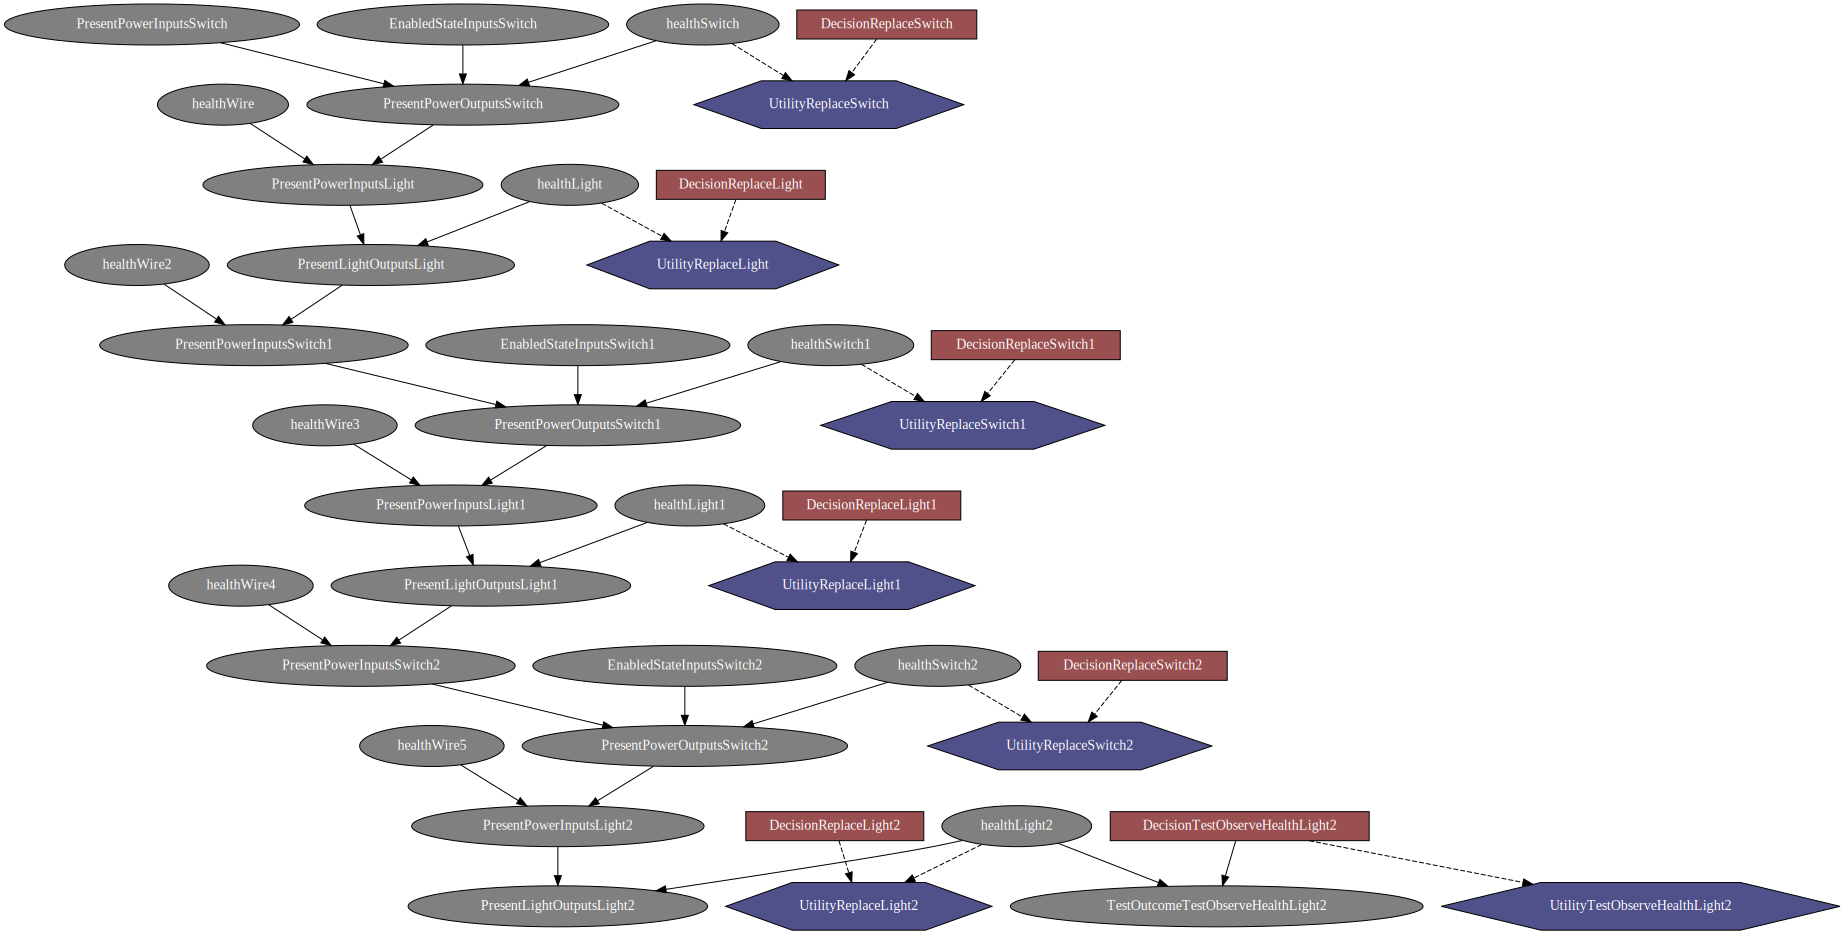

In [251]:
# main method connecting all the parts

# create assembly containing components, connections and structure
components  = [switch, light]
connections = [wire, wire2]
assembly = {
    "components" : components,
    "connections": connections,
    "tests"      : tests,
    "structure"  : structure3,
    "testmapping": testmapping
}

# create diagram
diagram = gum.InfluenceDiagram()

# read structure, add to diagram
buildDiagram(diagram, assembly)

# add tests
addTests(diagram, assembly)

setProbabilitiesComponents(diagram, assembly)
setProbabilitiesConnections(diagram, assembly)

#showCPTs(diagram)

# add decisions/utilities to replace component to structure, calculate utilities
addReplaceDecisions(diagram, assembly)
replaceUtilityNodeIds = fillReplaceDecisionUtilities(diagram, assembly)
# print utility tables
for node in replaceUtilityNodeIds: print(diagram.utility(node))

# show diagram
visualizeStructure(diagram)
